In [107]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
#import eli5

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV

In [108]:
print(os.listdir("../"))

['tmp', 'dev', 'run', 'srv', 'proc', 'mnt', 'sys', 'bin', 'media', 'lib64', 'usr', 'home', 'lib', 'opt', 'sbin', 'var', 'etc', 'root', 'boot', 'content', '.dockerenv', 'tools', 'datalab', 'python-apt', 'lib32', 'NGC-DL-CONTAINER-LICENSE']


In [109]:
indpro_data = pd.read_csv("../content/drive/MyDrive/my new job/PwC/case_with_date.csv")
indpro_data.head()

,y,date,x1,x2,x3,x4,x5
0,NaN,2022-11-01,2.456,4.00,1386.96,6.4,406426
1,104.7474,2022-10-01,2.837,4.04,1462.59,4.4,405948
2,104.8129,2022-09-01,2.578,3.56,1736.47,4.6,405466
3,104.4135,2022-08-01,2.793,3.13,1688.85,18.0,403957
4,104.4852,2022-07-01,3.283,3.10,1822.57,4.4,400415


In [110]:
indpro_data.index = pd.to_datetime(indpro_data.date)

In [111]:
features = ['x1','x2','x3','x4','x5']

In [112]:
indpro_data[features] = indpro_data[features].shift(periods=-1)

In [113]:
indpro_data = indpro_data.dropna()

In [114]:
indpro_data = indpro_data.drop('date', axis=1)

In [115]:
indpro_data.sort_index(inplace=True)

In [116]:
test_start = '2019-01-01'

df_train = indpro_data[:test_start].copy()
df_test = indpro_data[test_start:].copy()

print("Test set fraction:", len(df_test) / len(indpro_data))

Test set fraction: 0.1684981684981685


In [117]:
X_train = df_train[features].values
y_train = df_train['y'].values
index_train = df_train.index


X_test = df_test[features].values
y_test = df_test['y'].values
index_test = df_test.index

In [118]:
y = indpro_data['y']
X = indpro_data[features]
index = indpro_data.index

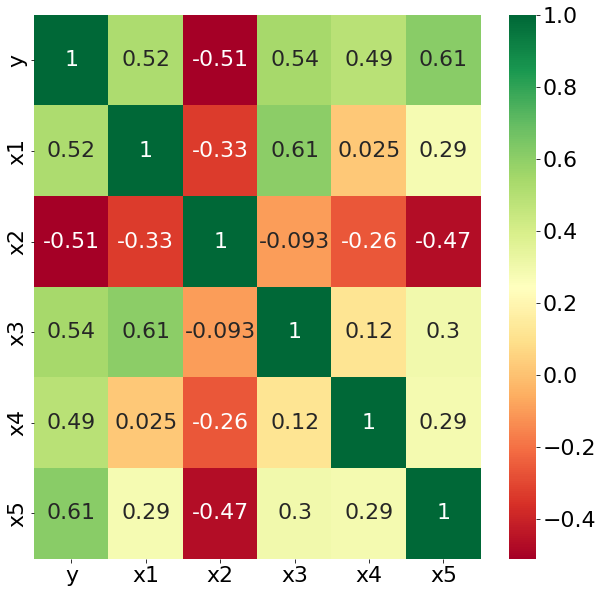

In [119]:
def correlation_heatmap(X):
    correlations = indpro_data.corr()
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap="RdYlGn",
                annot=True)
    plt.show();
    
correlation_heatmap(X)

In [120]:
X = X.values
y = y.values

In [121]:
tscv = TimeSeriesSplit(n_splits = 10)
mse_xgb = []
rmse_xgb = []
mae_xgb = []

model_CV = xgboost.XGBRegressor(objective='reg:squarederror', seed=20)

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

clf = RandomizedSearchCV(estimator=model_CV,
                         cv=tscv,
                         param_distributions=params, 
                         scoring='neg_mean_absolute_error', 
                         n_iter=25, 
                         verbose=1)

clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Best estimator:", clf.best_estimator_)
print("Mean cross-validated MAE of the best_estimator: ", (-clf.best_score_))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.3, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.8999999999999999}
Best estimator: XGBRegressor(colsample_bylevel=0.8999999999999999,
             colsample_bytree=0.7999999999999999, learning_rate=0.3,
             max_depth=20, n_estimators=500, objective='reg:squarederror',
             seed=20, subsample=0.7)
Mean cross-validated MAE of the best_estimator:  3.020771382293701


XGBoost - Root Mean Square Error (RMSE): 3.592
XGBoost - Mean Square Error (MSE): 12.903
XGBoost - Mean Absolute Error (MAE): 2.254
XGBoost - R2 score: 28.000000000000004%


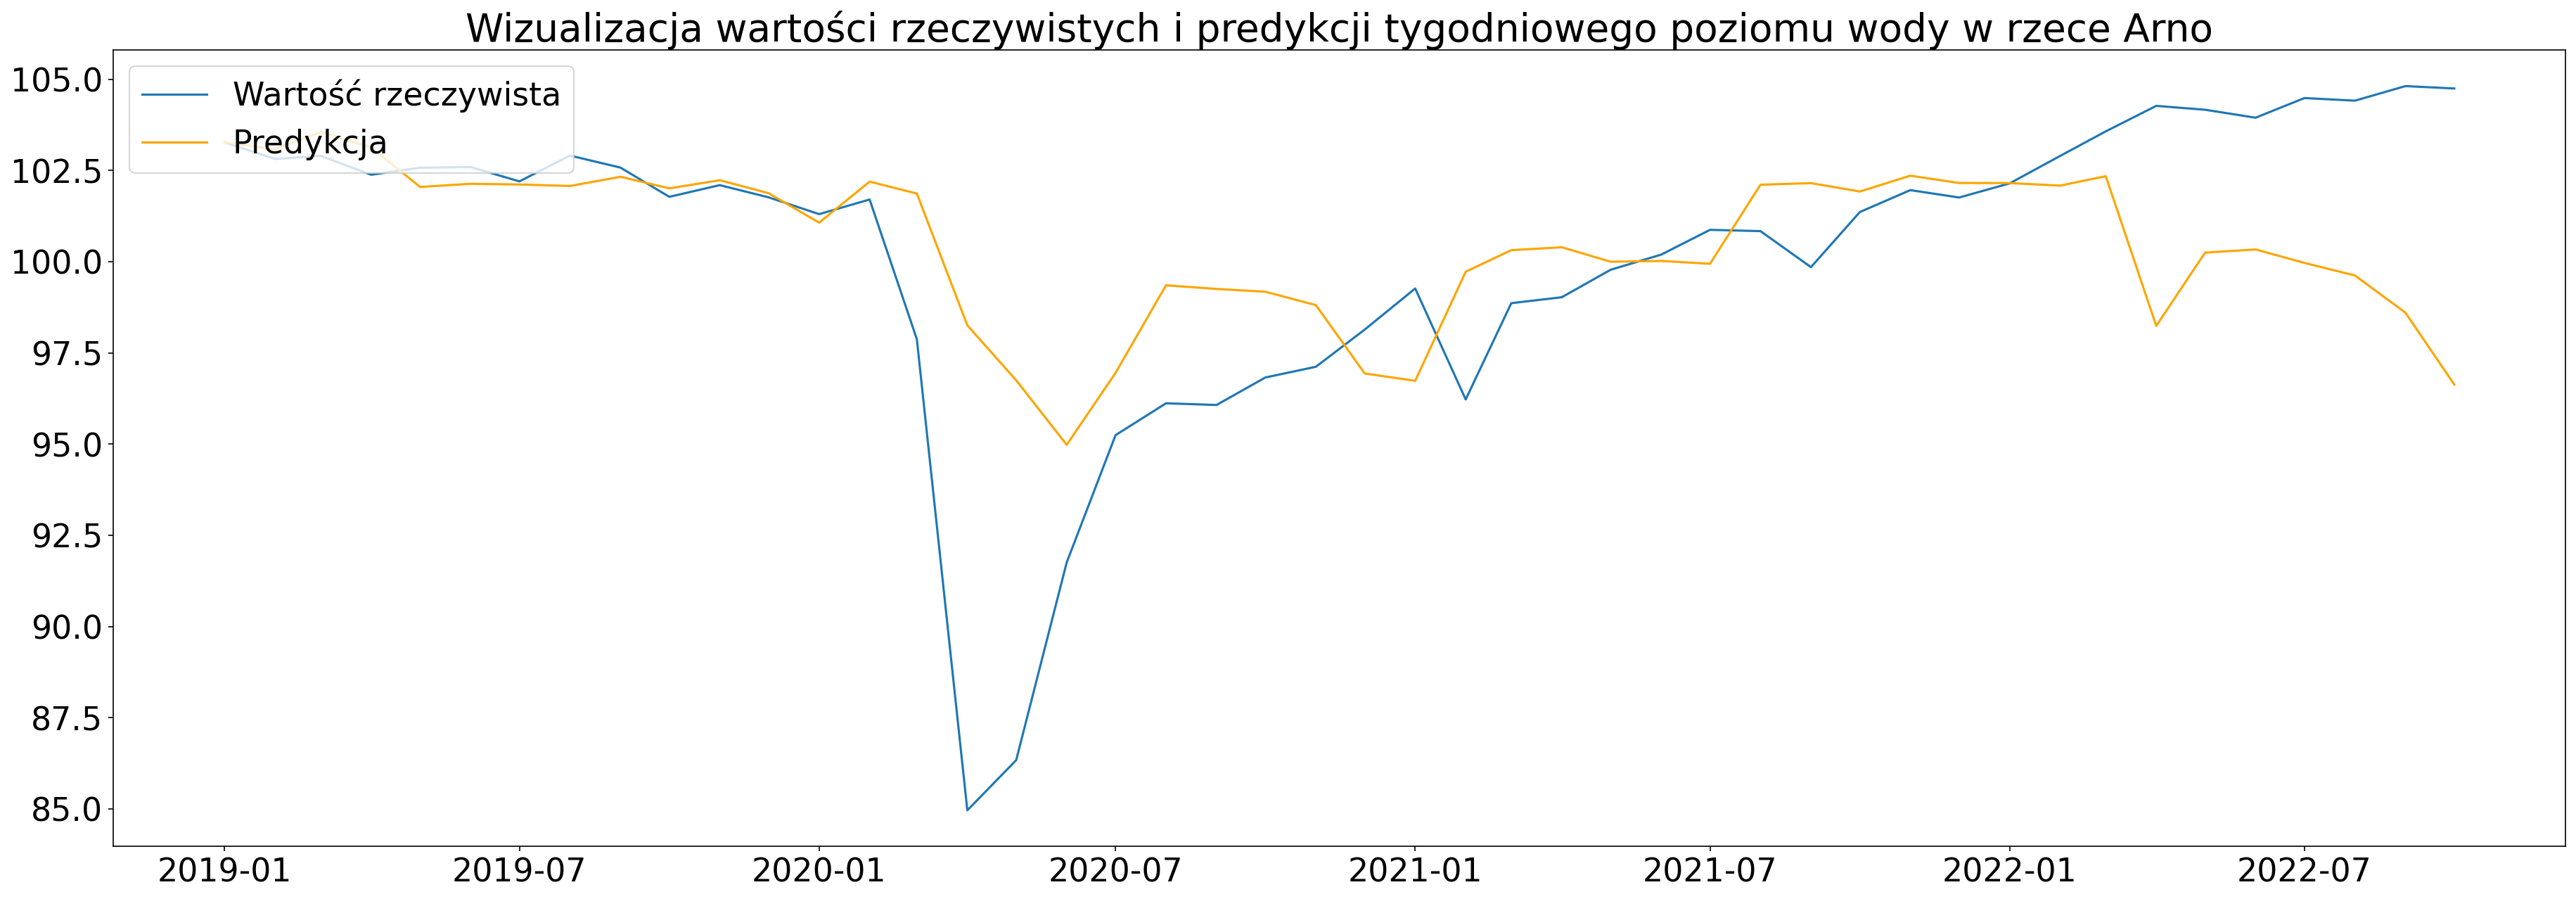

In [122]:
model = xgboost.XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.7999999999999999,
             learning_rate=0.3, max_depth=20, n_estimators=1000,
             objective='reg:squarederror', seed=20,
             subsample=0.7999999999999999)

model.fit(X_train, y_train)

predictions_xgb = model.predict(X_test)

mse_xgb = mean_squared_error(y_test, predictions_xgb)
rmse_xgb = sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
r2_xgb = r2_score(y_test, predictions_xgb)

print("XGBoost - Root Mean Square Error (RMSE): %.3f" % rmse_xgb)
print("XGBoost - Mean Square Error (MSE): %.3f" % mse_xgb)
print("XGBoost - Mean Absolute Error (MAE): %.3f" % mae_xgb)
print("XGBoost - R2 score: {}%".format(round(r2_xgb, 2) *100))

plt.figure(figsize=(30,10), dpi=150)
plt.rcParams.update({'font.size': 22})
plt.plot(index_test, y_test, label='Wartość rzeczywista')
plt.plot(index_test, predictions_xgb,color='orange', label='Predykcja')
plt.legend(loc="upper left")
plt.title('Wizualizacja wartości rzeczywistych i predykcji tygodniowego poziomu wody w rzece Arno')
plt.show()

In [123]:
#eli5.show_weights(model, feature_names=feats, top=30)